In [189]:
# align transcript to speech with CTC segmentation algorithm
# Wav2Vec2 model is used for acoustic feature extraction

import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.11.0+cu113
0.11.0+cu113
cuda


In [190]:
# %matplotlib inline

from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)

#SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_FILE = r"/workspace/datasets/LibriSpeech-test-clean/test-clean/1089/134686/1089-134686-0001.flac"

In [191]:
# generate the label class probability of each audio frame using wav2vec2
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

# trellis matrix
# probability of labels aligned at time step
emission = emissions[0].cpu().detach()

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


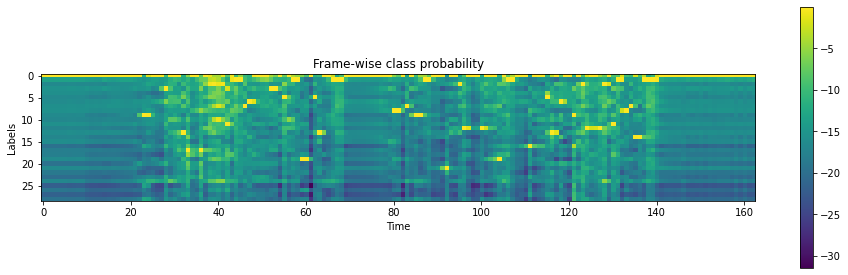

In [192]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [193]:
#transcript = "I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT"
transcript = "STUFF|IT|INTO|YOU|HIS|BELLY|COUNSELLED|HIM"
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('S', 9), ('T', 3), ('U', 13), ('F', 17), ('F', 17), ('|', 1), ('I', 7), ('T', 3), ('|', 1), ('I', 7), ('N', 6), ('T', 3), ('O', 5), ('|', 1), ('Y', 19), ('O', 5), ('U', 13), ('|', 1), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('B', 21), ('E', 2), ('L', 12), ('L', 12), ('Y', 19), ('|', 1), ('C', 16), ('O', 5), ('U', 13), ('N', 6), ('S', 9), ('E', 2), ('L', 12), ('L', 12), ('E', 2), ('D', 11), ('|', 1), ('H', 8), ('I', 7), ('M', 14)]


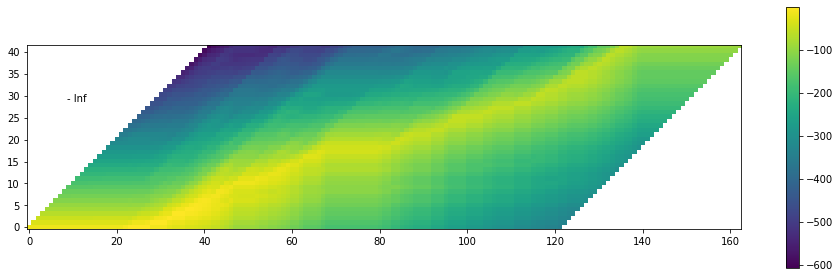

In [194]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [195]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=23, score=0.9999732971191406)
Point(token_index=0, time_index=24, score=0.23597459495067596)
Point(token_index=0, time_index=25, score=0.9999548196792603)
Point(token_index=0, time_index=26, score=0.9999890327453613)
Point(token_index=0, time_index=27, score=0.9997367262840271)
Point(token_index=1, time_index=28, score=0.9977419376373291)
Point(token_index=1, time_index=29, score=0.9989789724349976)
Point(token_index=1, time_index=30, score=0.9993870258331299)
Point(token_index=1, time_index=31, score=0.9989190101623535)
Point(token_index=2, time_index=32, score=0.9983355402946472)
Point(token_index=3, time_index=33, score=0.9836011528968811)
Point(token_index=3, time_index=34, score=0.9996689558029175)
Point(token_index=3, time_index=35, score=0.9997711777687073)
Point(token_index=4, time_index=36, score=0.9899522662162781)
Point(token_index=4, time_index=37, score=0.9921205043792725)
Point(token_index=4, time_index=38, score=0.3864060342311859)
Point(t

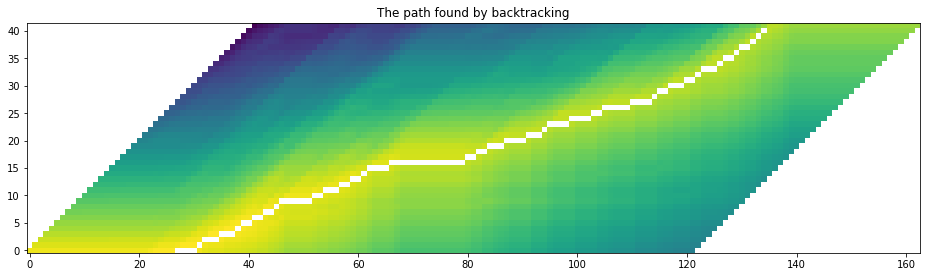

In [196]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [197]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

S	(0.85): [   23,    28)
T	(1.00): [   28,    32)
U	(1.00): [   32,    33)
F	(0.99): [   33,    36)
F	(0.79): [   36,    39)
|	(0.07): [   39,    40)
I	(0.30): [   40,    42)
T	(0.33): [   42,    44)
|	(0.50): [   44,    46)
I	(1.00): [   46,    47)
N	(0.79): [   47,    53)
T	(1.00): [   53,    55)
O	(0.67): [   55,    58)
|	(0.50): [   58,    60)
Y	(1.00): [   60,    62)
O	(1.00): [   62,    63)
U	(0.77): [   63,    67)
|	(0.86): [   67,    81)
H	(1.00): [   81,    83)
I	(1.00): [   83,    85)
S	(0.34): [   85,    88)
|	(1.00): [   88,    92)
B	(1.00): [   92,    95)
E	(1.00): [   95,    96)
L	(0.93): [   96,   100)
L	(0.98): [  100,   104)
Y	(1.00): [  104,   106)
|	(0.80): [  106,   111)
C	(1.00): [  111,   115)
O	(0.99): [  115,   116)
U	(0.85): [  116,   118)
N	(0.99): [  118,   121)
S	(0.99): [  121,   123)
E	(1.00): [  123,   124)
L	(0.84): [  124,   127)
L	(0.99): [  127,   128)
E	(0.89): [  128,   130)
D	(1.00): [  130,   131)
|	(0.59): [  131,   133)
H	(1.00): [  133,   134)


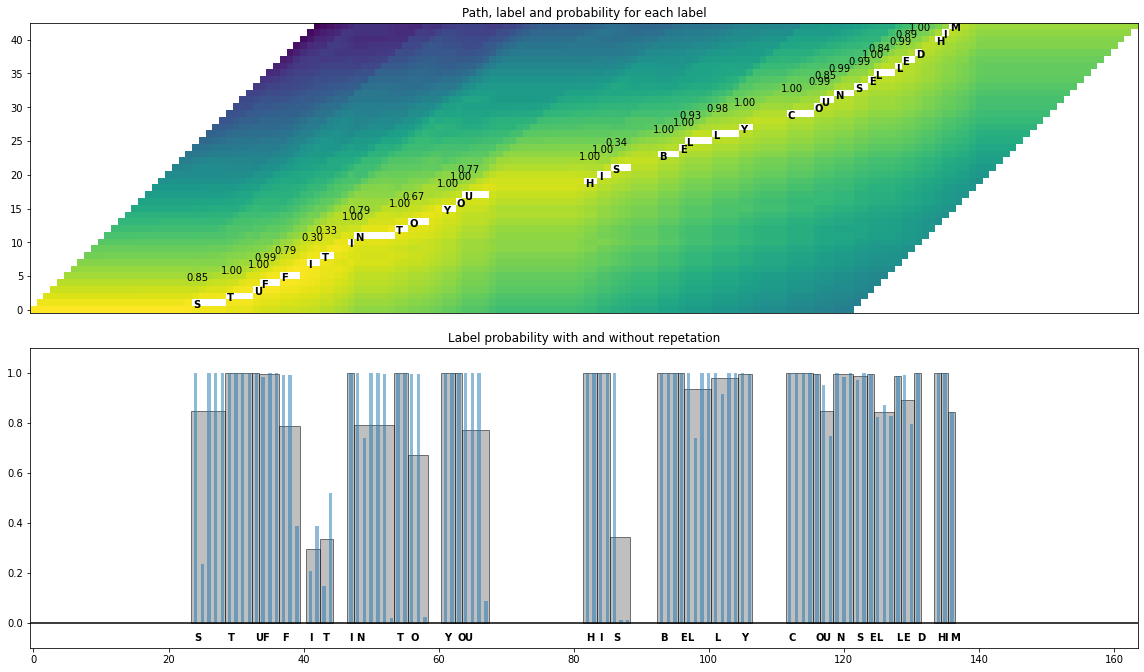

In [198]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [199]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

STUFF	(0.91): [   23,    39)
IT	(0.32): [   40,    44)
INTO	(0.81): [   46,    58)
YOU	(0.87): [   60,    67)
HIS	(0.72): [   81,    88)
BELLY	(0.97): [   92,   106)
COUNSELLED	(0.95): [  111,   131)
HIM	(0.95): [  133,   136)


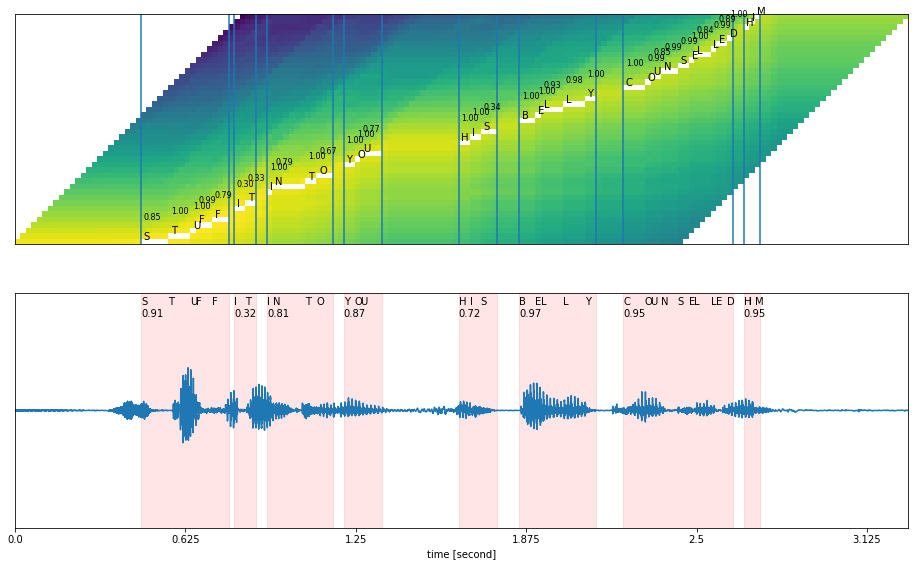

num words: 8


In [200]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()
print("num words: " + str(len(word_segments)))

In [201]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
from scipy.io.wavfile import write
import numpy as np

def write_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    torchaudio.save(f"/workspace/projects/Alignment/wav2vec2/outputs/test1/segment{i}.wav", segment, bundle.sample_rate)
    #write(f"/workspace/projects/Alignment/wav2vec2/outputs/test1/segment{i}.wav", bundle.sample_rate, segment)

# Generate the audio for each segment
for i in range(len(word_segments)):
    segm = write_segment(i)

STUFF (0.91): 0.462 - 0.784 sec
IT (0.32): 0.804 - 0.884 sec
INTO (0.81): 0.924 - 1.165 sec
YOU (0.87): 1.206 - 1.346 sec
HIS (0.72): 1.627 - 1.768 sec
BELLY (0.97): 1.848 - 2.130 sec
COUNSELLED (0.95): 2.230 - 2.632 sec
HIM (0.95): 2.672 - 2.732 sec
